# Amazon Review - Machine Learning Project
Done as a final project for Udacity's machine learning nano degree. For more information, check our their [website](www.udacty.com).
 

## Project Overview
The quality of the comments made on internet forums has always suffered due to anonymity of it’s
users. When users comments on, for instance, a YouTube video, there is no repercussion for what they
say, and the dialogue generated is often not helpful. Different websites have tried different methods for
extracting more useful comments. Reddit uses an upvote system, Quora fosters a community that
values high quality responses over low quality ones, and Amazon allows for it’s users to to rate the
“helpfulness” of reviews left on their products. Amazon’s system, in particular, then allows for the
higher rated comments to be displayed at the top of the review forum so that new users can see the top
rated comments in order to help them make their own purchasing decisions.

Even though Amazon’s helpfulness rating system seems to work on the surface level, poor quality
comments still seem to be at the top of their review forms. Having poor quality reviews hurts Amazon’s
business, as a major reason that people are willing to buy consumer goods online without seeing the
items themselves, is that they have access to others peoples opinions of the item. For example, a review
at the top of an app called [“Friday Night at Freddies 4”](https://www.amazon.com/Five-Nights-at-Freddys-4/dp/B012J53LKY) is as follows:

>“I love this game so much but at first I though it was lame but when I go in the game I can't
beat the first night because cause I put it to full volume and I can't here the breathing
bonnie strike at 4 am Chica at 5 and plus it not lame it's better than fnaf and fnaf 2 plus get
this game when u buy fnaf”

This comment, despite being at the top of the forum, is difficult to understand, a run on sentence, and
full of spelling errors. The reason for the failure is part of the algorithm for determining the order of the
reviews relies on how recently the review has been made. The offending review was the most recent,
but it’s helpfulness score was far less than previous reviews. This illustrates the difficult balance that
must be struck between showing the highest rated reviews, and showing the newest reviews, to be rated
by the community. An ideal system would predict if a review is helpful or not, so that poor quality
reviews would not need to be displayed the top.

### Problem Statement

The problem being addressed in this project is the poor quality of Amazon reviews at the top of the
forum despite the “helpfulness” rating system. The problem arises from the “free pass” given to new
reviews to be placed at the top of the forum, for a chance to be rated by the community. The proposed
solution to this problem is to use machine learning techniques to design a system that “pre-rates” new
reviews on their “helpfulness” before they are given a position at the top of the forum. This way, poor
quality reviews will be more unlikely to be shown at the top of the forum, as they do not get the “freepass” because they are new. The proposed system will use a set of Amazon review data to train itself to
predict a helpfulness classification (helpful, or not helpful) for new input data.

The data used for this project is provided by the University of California, San Diego and is available at Julian McAuley's [research page](http://jmcauley.ucsd.edu/data/amazon/). See the references at the end of this project for more information. As the original set is massive, we will only look at a subset of the data: the reviews for [apps for Android](http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Apps_for_Android_5.json.gz). 

### Metrics

Since our problem is a binary classification problem (helpful or not helpful). We will use the ‘Receiver
Operator Characteristic Area Under the Curve’ or `roc_auc score` to evaluate our model. The curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR). The area under the curve is used to give a score to the model. If the area under the curve is 0.5, then the TPR is equal to the FPR, and the model is
doing no better than random guessing. A perfect model would have an AUC of 1.0, meaning it has 100%
TPR. For more information on the rox_auc score please visit the [sklearn page](http://scikit-learn.org/stable/modules/model_evaluation.html#roc-metrics). The University of Nebraska Medical Center, also has a good explanation [page.](http://gim.unmc.edu/dxtests/roc3.htm)

## Analysis

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import unicodedata
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
import pandas as pd
import gzip
import seaborn as sns
import string

import nltk
from nltk.corpus import stopwords 
stops = set(stopwords.words("english"))
from gensim.models import Word2Vec
from bs4 import BeautifulSoup 
import re
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve

from IPython.display import display # Allows the use of display() for DataFrames


import warnings
warnings.filterwarnings('ignore')

# Config the matlotlib backend as plotting inline in IPython
%matplotlib inline

# Lets define some helpful constants
DATASET_NAME = 'reviews_Apps_for_Android_5.json.gz'

# A size for figures
FIG_SIZE = (14,8)

#Random state for classifiers
RAN_STATE = 42


/home/tyler/anaconda2/lib/python2.7/site-packages/gensim/utils.py:1015: UserWarning: Pattern library is not installed, lemmatization won't be available.
  warnings.warn("Pattern library is not installed, lemmatization won't be available.")
/home/tyler/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Data Exploration
If a dataset is present, features and calculated statistics relevant to the problem have been reported and discussed, along with a sampling of the data. In lieu of a dataset, a thorough description of the input space or input data has been made. Abnormalities or characteristics about the data or input that need to be addressed have been identified.

First we will check if we have already downloaded the dataset. If not, we will download it.

In [2]:
url = 'http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/'
last_percent_reported = None

def download_progress_hook(count, blockSize, totalSize):
    """A hook to report the progress of a download. This is mostly intended for users with
    slow internet connections. Reports every 1% change in download progress.
    """
    global last_percent_reported
    percent = int(count * blockSize * 100 / totalSize)

    if last_percent_reported != percent:
        if percent % 5 == 0:
            sys.stdout.write("%s%%" % percent)
            sys.stdout.flush()
        else:
            sys.stdout.write(".")
            sys.stdout.flush()
            
        last_percent_reported = percent
                
def maybe_download(filename, expected_bytes, force=False):
    """Download a file if not present, and make sure it's the right size."""
    if force or not os.path.exists(filename):
        print('Attempting to download:', filename) 
        filename, _ = urlretrieve(url + filename, filename, reporthook=download_progress_hook)
        print('\nDownload Complete!')
    statinfo = os.stat(filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified', filename)
    else:
        raise Exception(
            'Failed to verify ' + filename + '. Can you get to it with a browser?')
    return filename

test = maybe_download(DATASET_NAME, 95509687)


Found and verified reviews_Apps_for_Android_5.json.gz


We need to extract the data, and convert the data given in "json" to a dataframe in order to perform our analysis. To save time for later we will pickle the file.

In [3]:
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

def getDF(path):
    i = 0
    data = {}
    for d in parse(path):
        data[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

#removes extensions and adds pickle.
pickle_file_name = (DATASET_NAME[:-8]+'.pickle')

#loads pickle if exists, extracts and pickles if it doesn't
if os.path.exists(pickle_file_name):
    print ('Pickled file already present, loading...')
    data = pd.read_pickle(pickle_file_name)
    print ('Pickle file loaded.')
else:
    data = getDF(DATASET_NAME)
    data.to_pickle(pickle_file_name)



Pickled file already present, loading...
Pickle file loaded.


OK now lets have a look at the data.

In [4]:
data.head(1)

,reviewerID,asin,reviewerName,helpful,unixReviewTime,reviewText,overall,reviewTime,summary
0,A1N4O8VOJZTDVB,B004A9SDD8,Annette Yancey,"[1, 1]",1383350400,"Loves the song, so he really couldn't wait to ...",3.0,"11 2, 2013",Really cute


The `helpful` score can be explained as follows: a user can either rate the review as 'helpful’ or ‘not
helpful’. The dataset records each of these in an array. For our problem we want to classify the email as
either ‘helpful’ or not ‘helpful’. For training, this label can be generated by dividing the ‘helpful’
ratings by the total ratings and seeing if it exceeds a certain threshold.

Lets extract the information we need for this project:

* The 'reviewText' will be used to generate features using natural language processing.
* The score will be used as a feauture in our final model
* The 'helpful' rating will be used to generate labels. We will train our model using these training labels. Predict the label using the test features, and measure the success of our model using the test labels. This will be explained more later.

Other features that could be important would be the summary; however, in the interest of keeping this simple, we will exclude it from the analysis.

In [5]:
#select the columns
df = data.iloc[:, [6,5,3]]

#split numerator and denominator
df['helpful_numerator'] = df['helpful'].apply(lambda x: x[0])
df['helpful_denominator'] = df['helpful'].apply(lambda x: x[1])

# delete un-needed 'helpful catagory
del df['helpful']

#Check if we have any null values
print (df.isnull().sum())


overall                0
reviewText             0
helpful_numerator      0
helpful_denominator    0
dtype: int64


Lets have a quick look at the stats..

In [6]:
df.describe()

,overall,helpful_numerator,helpful_denominator
count,752937.000000,752937.000000,752937.000000
mean,3.968931,3.435937,4.473125
std,1.342484,37.328951,43.688824
min,1.000000,0.000000,0.000000
25%,3.000000,0.000000,0.000000
50%,5.000000,0.000000,0.000000
75%,5.000000,1.000000,2.000000
max,5.000000,8116.000000,9258.000000


There are clearly some outliers and weird numbers in here. Lets move on to some visualization.

### Exploratory Visualization
A visualization has been provided that summarizes or extracts a relevant characteristic or feature about the dataset or input data with thorough discussion. Visual cues are clearly defined.

Lets have a look at how our data is distributed.

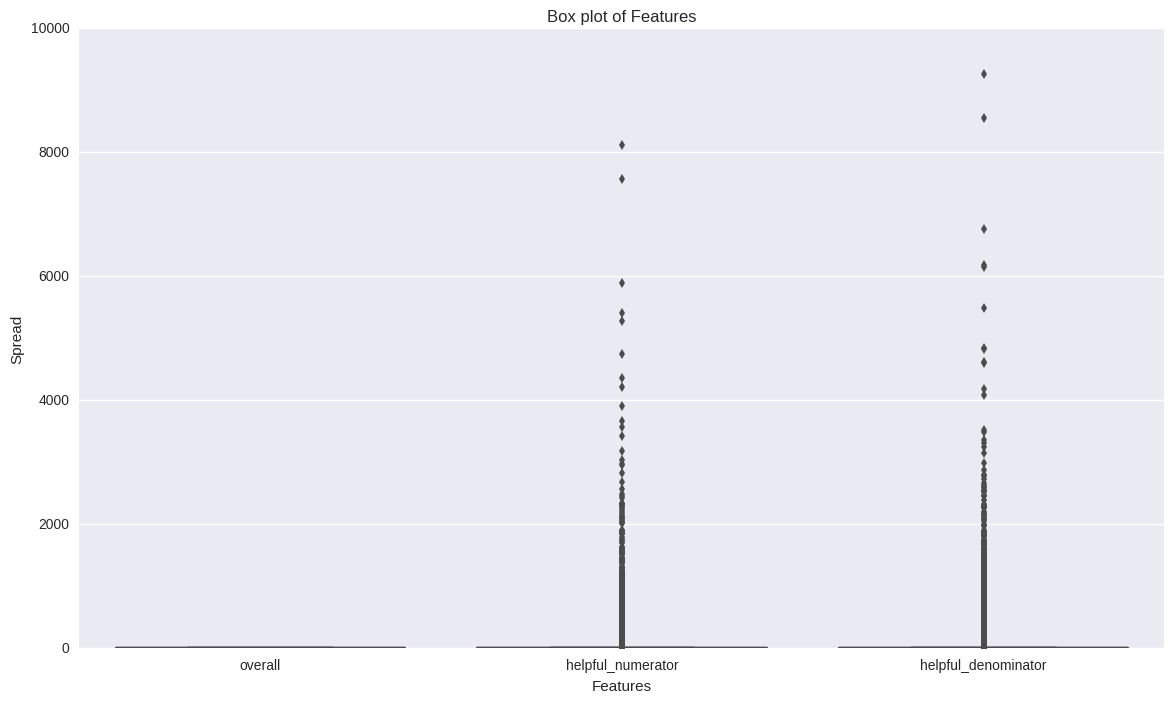

In [7]:
### Box Plot
plt.figure(figsize=FIG_SIZE)
plt.title('Box plot of Features')
plt.ylabel('Spread')
plt.xlabel('Features')

display(sns.boxplot(df[df.columns]))

This is pretty ugly, let's have a look at some of the outliers and make sure they are valid data.

In [8]:
print (df['helpful_numerator'].idxmax(axis=0, skipna=True))
print (df['helpful_denominator'].idxmax(axis = 0, skipna = True))

510127
510127


In [9]:
df.iloc[[510127]]

,overall,reviewText,helpful_numerator,helpful_denominator
510127,5.0,This game is the perfect sequel to Temple Run....,8116,9258


This looks fine to me. Moving on.

### Algorithms and Techniques
Algorithms and techniques used in the project are thoroughly discussed and properly justified based on the characteristics of the problem.

### Benchmark
Student clearly defines a benchmark result or threshold for comparing performances of solutions obtained.

## Methodology

### Data Preprocessing
All preprocessing steps have been clearly documented. Abnormalities or characteristics about the data or input that needed to be addressed have been corrected. If no data preprocessing is necessary, it has been clearly justified.

Data that has had less than 10 ratings will first be trimmed out of the dataset. There are a significant amount of reviews, and many do not face the scrutiny of people reading them. So these data points will influence our analysis, as they could be good reviews, but have no one read them.

In [10]:
#include reviews that have more than 10 helpfulness data point only
df1 = df[(df.helpful_denominator > 10)].copy()
df1.shape

(47932, 4)

In order to perform our analysis, we wish to determine if a given review text is helpful or not. We need a way to map the existing data to this binary classification. The chosen method is to use a threshold of 'helpful_numerator' divided by 'helpful_denominator'. In other words, the ratio of the people who found the review helpful over the amount of people who rated the review as helpful or unhelpful. If this ratio exceeds a certain threshold value, we can label the training data as 'helpful' = 1, or 'non-helpful' = 0

In [11]:
#transform Helpfulness into a binary variable with 0.50 ratio
threshold = 0.5
df1.loc[:, 'Helpful'] = np.where(df1.loc[:, 'helpful_numerator'] \
                                 / df1.loc[:, 'helpful_denominator'] > threshold, 1, 0)
df1.head(3)

,overall,reviewText,helpful_numerator,helpful_denominator,Helpful
33,3.0,"I did the 7-day trial and was impressed, but a...",15,20,1
94,5.0,"This app is great! It has a daily verse, a da...",96,107,1
284,2.0,This app simply latches on to Google maps and ...,11,23,0


In [12]:
#Lets check the balance
print ('Count:')
display(df1.groupby('Helpful').count())


Count:


,overall,reviewText,helpful_numerator,helpful_denominator
Helpful,,,,
0,6210,6210,6210,6210
1,41722,41722,41722,41722


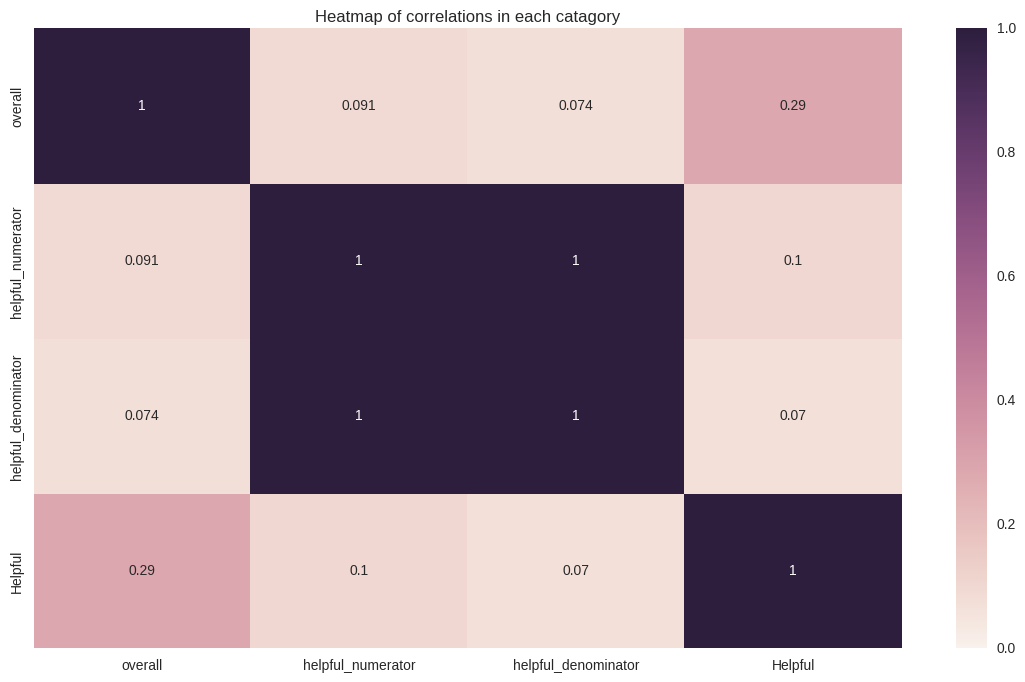

In [13]:
#visualize correlation of the data
correlations = df1.corr()
plt.figure(figsize = FIG_SIZE)
plt.title("Heatmap of correlations in each catagory")
_ = sns.heatmap(correlations, vmin=0, vmax=1, annot=True)


We can see that our dataset in unbalanced, with roughly 7 times as many effective reviews as ineffective reviews. This means that when we are splitting our data later, we will need to use a stratified shuffle so that both categories have proportional representation in training.

We can also see that there is a small correlation between the score and the 'Helpful' rating. It is good that this correlation is small, or else our job would be very easy and we wouldn't need to generate features from the reviewText at all, we could just look at the score of the review. 

### Text Feature Generation
Now lets convert the text to lower case so we can run our natural language processing to produce features. We will also remove punctuation. Removing punctuation may seem like it should not be done in the case of this problem, as not having punctuation will make a review harder to understand. This is a trade-off that we must consider as if you have punctuation, it will cause the learning algorithm to behave poorly.

In [14]:
# convert text to lowercase
df1.loc[:, 'reviewText'] = df1['reviewText'].str.lower()

def remove_punctuation(text):
    return text.translate(None, string.punctuation.translate(None, '"'))

df1['reviewText']=df1['reviewText'].apply( lambda x: remove_punctuation(x))
df1['reviewText'].head(4)

33     i did the 7day trial and was impressed but am ...
94     this app is great  it has a daily verse a dail...
284    this app simply latches on to google maps and ...
288    unable to move to sd card uninstalled cannot r...
Name: reviewText, dtype: object

In order to generate more features we will use the [TF-IDF vectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) from the sci-kit learn library. We will also use the [NLTK](http://www.nltk.org/) library. The pre-processing methods that we are going to employ are as follows:

* __Stemming__ - Stemming means to take off the suffixes of the stemmed word. Therefore words such as "run" and "running" would both be represented as "run". This allows for our algorithms to more accurate find trends in the "meanings" of sentences (e.g "the sun is shining" and "the sun shines" will more accurately be associated with the same meaning. It will reduce the total amount of features that we will generate.
* __Tolkenizing__- Splits sentences up into single words. This is needed to generate our TFIDF features.
* __Remove Stop Words__- This moves words such as "the" "a" and "it" as shown in the English stop words [corpus](http://www.nltk.org/howto/corpus.html). These will only clutter up our learning algorithm. Admittingly, sentences without these words are hard to understand, and ideally they should be kept, but it is again a trade-off.
* __ngrams__- Makes groups of words that are 'n' long. E.g the 2-grams for the sentence "The shaggy dog" are [The, shaggy], [The, dog] and [shaggy, dog]. Weving more than that is computationally expensive for my computer. will stick to 2-grams and 1-grams for now. Having more than that is computationally expensive.

Finally we will generate TF-IDF scores for each of the stemmed and tolkenized words and ngrams. TF-IDF is short for _Term Frequency Inverse Document frequency_. TF-IDF is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus. It is often used as a weighting factor in information retrieval and text mining. For more information check out this [link.](http://www.tfidf.com/)

For our vectorizer, we will also set the min_df to 0.001. This is a cheap way of getting rid of spelling mistakes. Words that appear this infrequently are most likely typos and are uninteresting to our algorithm.

In [15]:
#tokenize text with Tfidf
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.snowball import SnowballStemmer

#create a stemmer
stemmer = SnowballStemmer("english")


#define our own tokenizing function that we will pass into the TFIDFVectorizer. We will also stem the words here.
def tokens(x):
    x = x.split()
    stems = []
    [stems.append(stemmer.stem(word)) for word in x]
    return stems

#define the vectorizer
vectorizer = TfidfVectorizer(tokenizer = tokens, stop_words = 'english', ngram_range=(1, 1), min_df = 0.01)
#fit the vectorizers to the data.
features = vectorizer.fit_transform(df1['reviewText'])


vocab = vectorizer.get_feature_names()
features.shape




(47932, 445)

We have now generated all of the features that we are going to need. 


### Benchmark model (Bag of Words)
In order to establish a baseline for the project, we will use a Bag of Words model. A Bag of Words model is trained entirely using the TFIDF features that we just generated. Now we will shuffle and split the data into 80% training and 20% testing.

In [57]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features,df1['Helpful'], test_size=0.2, random_state=RAN_STATE)

The benefit to splitting the data into testing and training sets is that this allows simulated evaluation of how well the model is performing before using it in the real world to make predictions.
If there was no testing set, there would be no way of realistically evaluating the model as you would only be able to measure it's performace on data to which it's already been exposed. This will result in a false sense of confidence in how well the model performs.

### Grid Search

The grid search technique works by generating a grid of all possible provided parameter combinations. It then evaluates a model using a validation set based on every combination of parameters in the grid. It is used to find the optimum set of parameters for a learning algorithm given a data set.


### Cross-Validation
The k-folds validation training technique creates multiple testing and training sets and trains a model on each, averaging the results. The splitting method is to divide the data into separate bins (for example k = 5), train on bins 1 to k-1 and test on bin k. The next fold trains on bins 2 to k and tests on bin 1 and so on, until all of the bins have acted as a test bin. This effectively trains and tests the models on all of the data without over-fitting to the data.

The benefits that this provides for grid search while optimizing the model is that there is less of a chance that the final model won't be optimized to data that could potentially have a bias. For example, if somehow, all of the training data didn't contain a unique data point (such as a high MEDV value for a low RM) the final model would be very biased not predict this scenario, and the optimization will make that worse. However, with k-folds validation, one of the trained models will see the unique data point and the result will be reflected in the final averaged model.

In [17]:
#find best logistic regression parameters using grid search and cross validation.
from sklearn import grid_search, cross_validation
from sklearn.linear_model import LogisticRegression


gs = grid_search.GridSearchCV(
    estimator=LogisticRegression(),
    param_grid={'C': [10**i for i in range(-5,10)], 'class_weight': [None, 'balanced']},
    cv=cross_validation.StratifiedKFold(y_train,n_folds=5),
    scoring='roc_auc'
)

gs.fit(X_train, y_train)
gs.grid_scores_

[mean: 0.62100, std: 0.00886, params: {'C': 1e-05, 'class_weight': None},
 mean: 0.71721, std: 0.00878, params: {'C': 1e-05, 'class_weight': 'balanced'},
 mean: 0.63316, std: 0.00883, params: {'C': 0.0001, 'class_weight': None},
 mean: 0.71759, std: 0.00881, params: {'C': 0.0001, 'class_weight': 'balanced'},
 mean: 0.68943, std: 0.00909, params: {'C': 0.001, 'class_weight': None},
 mean: 0.72108, std: 0.00903, params: {'C': 0.001, 'class_weight': 'balanced'},
 mean: 0.73067, std: 0.00992, params: {'C': 0.01, 'class_weight': None},
 mean: 0.73651, std: 0.00978, params: {'C': 0.01, 'class_weight': 'balanced'},
 mean: 0.74680, std: 0.01027, params: {'C': 0.1, 'class_weight': None},
 mean: 0.74839, std: 0.00984, params: {'C': 0.1, 'class_weight': 'balanced'},
 mean: 0.74671, std: 0.00979, params: {'C': 1, 'class_weight': None},
 mean: 0.74500, std: 0.00967, params: {'C': 1, 'class_weight': 'balanced'},
 mean: 0.74388, std: 0.00977, params: {'C': 10, 'class_weight': None},
 mean: 0.74291, s

We can see that the best classifier has a 'C' value of 0.1 and a 'class_weight' = 'balanced'. We will now use this to make our predictions and plot the ROC curve. Below, the `predict_proba` function gives us the probability that the data-point lies in each class ('helpful' or 'non-helpful').

<function matplotlib.pyplot.show>

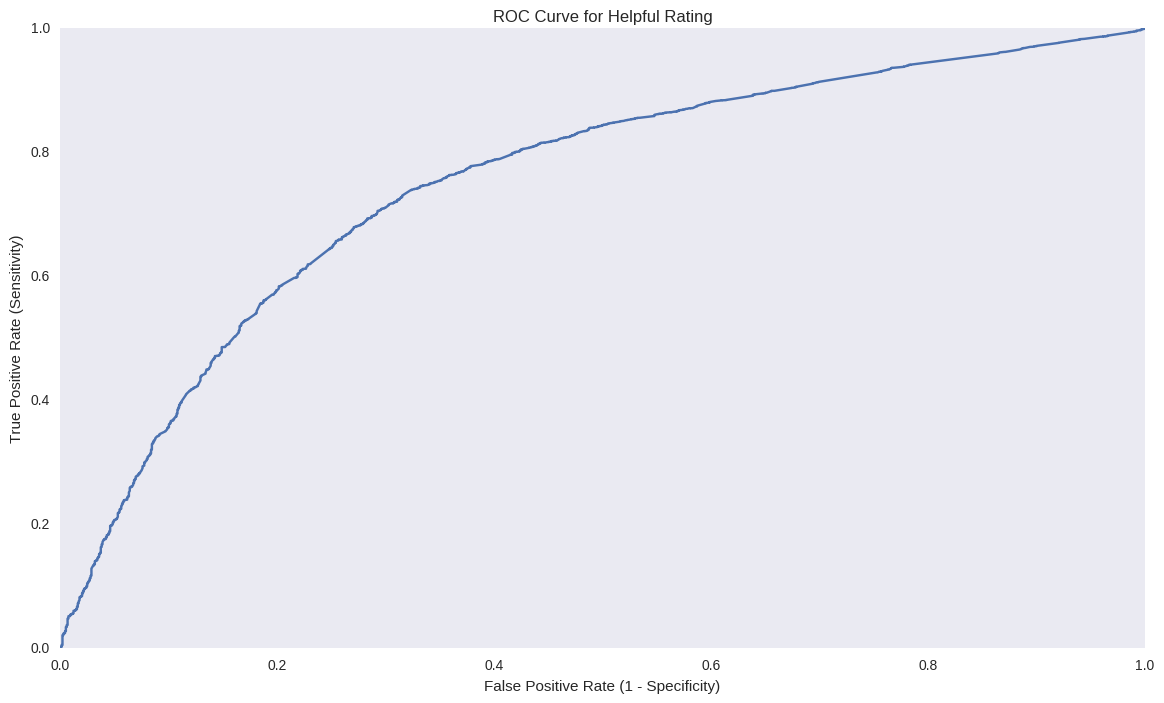

In [68]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier()
clf = clf.fit(X_train,y_train)
probas =clf.predict_proba(X_test)
plt.figure(figsize = FIG_SIZE)
plt.plot(roc_curve(y_test, probas[:,1])[0], roc_curve(y_test, probas[:,1])[1])
plt.title('ROC Curve for Helpful Rating')
plt.grid()
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.show

In [69]:
# ROC/AUC score
roc_auc_score(y_test, probas[:,1].T)

0.75205169373081937

The ROC_AUC score for our benchmark model is 0.7485. Let see if we can improve this.

### Statistical nomenclature
Before we continue, here is a small note on some statistical terms.
* __Specificity__: The true negative rate. I.e the amount of true negatives that are predicted.
* __Sensitivity__: The true positive rate. Also know as the _Recall_.
* __Precision__: The true positives divided by the total amount of positives.

## Refinement

The process of improving upon the algorithms and techniques used is clearly documented. Both the initial and final solutions are reported, along with intermediate solutions, if necessary.

In order to improve our results, we are going to used the Word2Vec algorithm. Much of this code is taken from the [tutorial](https://www.kaggle.com/c/word2vec-nlp-tutorial/details/part-2-word-vectors) on word2Vec on the kaggle website

In [20]:
def review_to_words( review ):
    """
    Return a list of cleaned word tokens from the raw review
    
    """
        
    #Remove any HTML tags and convert to lower case
    review_text = BeautifulSoup(review).get_text().lower() 
    
    #Replace smiliey and frown faces, ! and ? with coded word SM{int} in case these are valuable
    review_text=re.sub("(:\))",r' SM1',review_text)
    review_text=re.sub("(:\()",r' SM2',review_text)
    review_text=re.sub("(!)",r' SM3',review_text)
    review_text=re.sub("(\?)",r' SM4',review_text)
    
    #keep 'not' and the next word as negation may be important
    review_text=re.sub(r"not\s\b(.*?)\b", r"not_\1", review_text)
    
    #keep letters and the coded words above, replace the rest with whitespace
    nonnumbers_only=re.sub("[^a-zA-Z\_(SM\d)]"," ",review_text)  
    
    #Split into individual words on whitespace
    words = nonnumbers_only.split()                             
    
    #Remove stop words
    words = [w for w in words if not w in stops]   
    
    return (words)



def avg_word_vectors(wordlist,size):
    """
    returns a vector of zero for reviews containing words where none of them
    met the min_count or were not seen in the training set
    
    Otherwise return an average of the embeddings vectors
    
    """
    
    sumvec=np.zeros(shape=(1,size))
    wordcnt=0
    
    for w in wordlist:
        if w in model:
            sumvec += model[w]
            wordcnt +=1
    
    if wordcnt ==0:
        return sumvec
    
    else:
        return sumvec / wordcnt

In [21]:
df1.head(1)

,overall,reviewText,helpful_numerator,helpful_denominator,Helpful
33,3.0,i did the 7day trial and was impressed but am ...,15,20,1


Messing around with stuff.

In [22]:
df1['word_list']=df1['reviewText'].apply(review_to_words)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(df1['word_list'], df1['Helpful'], \
                                                    test_size=0.2, random_state=RAN_STATE)

#size of hidden layer (length of continuous word representation)
dimsize=400

#train word2vec on 80% of training data
model = Word2Vec(X_train.values, size=dimsize)

#create average vector for train and test from model
#returned list of numpy arrays are then stacked 
X_train=np.concatenate([avg_word_vectors(w,dimsize) for w in X_train])
X_test=np.concatenate([avg_word_vectors(w,dimsize) for w in X_test])


In [25]:
# basic logistic regression with SGD

clf = gs.best_estimator_
clf.fit(X_train, y_train)
p=clf.predict_proba(X_test)
roc_auc_score(y_test,p[:,1])

0.72789210068170729

In [26]:
from sklearn.cluster import KMeans
from sklearn import metrics

model = KMeans(n_clusters=4, init='k-means++', max_iter=100, n_init=1,random_state=5)

In [28]:
X_train = vectorizer.transform(df1['reviewText'])
vocab = vectorizer.get_feature_names()
sse_err = []
res = model.fit(X_train)
vocab = np.array(vocab)
cluster_centers = np.array(res.cluster_centers_)
sorted_vals = [res.cluster_centers_[i].argsort() for i in range(0,np.shape(res.cluster_centers_)[0])]
words=set()
for i in range(len(res.cluster_centers_)):
    words = words.union(set(vocab[sorted_vals[i][-10:]]))
words=list(words)

#top 10 words for each cluster
words

[u'play',
 u'good',
 u'old',
 u'dont',
 u'just',
 u'app',
 u'great',
 u'free',
 u'realli',
 u'download',
 u'game',
 u'veri',
 u'love',
 u'kindl',
 u'kid',
 u'tri',
 u'use',
 u'like',
 u'work',
 u'time',
 u'fun']

In [29]:
#add top words to train set
train_set=X_train[:,[np.argwhere(vocab==i)[0][0] for i in words]]

In [33]:
# how many observations are in each cluster
df1['cluster'] = model.labels_
df1.groupby('cluster').count()

,overall,reviewText,helpful_numerator,helpful_denominator,Helpful,word_list
cluster,,,,,,
0,18646,18646,18646,18646,18646,18646
1,10201,10201,10201,10201,10201,10201
2,13400,13400,13400,13400,13400,13400
3,5685,5685,5685,5685,5685,5685


In [34]:
# what does each cluster look like
df1.groupby('cluster').mean()

,overall,helpful_numerator,helpful_denominator,Helpful
cluster,,,,
0,2.956237,38.868015,50.752869,0.834817
1,3.070777,47.463386,59.846976,0.850113
2,3.686866,47.288731,58.508731,0.900746
3,4.626737,52.356201,63.434653,0.952331


In [35]:
# correlation matrix
df1.corr()

,overall,helpful_numerator,helpful_denominator,Helpful,cluster
overall,1.000000,0.090528,0.073573,0.286067,0.308348
helpful_numerator,0.090528,1.000000,0.996263,0.103113,0.032038
helpful_denominator,0.073573,0.996263,1.000000,0.069678,0.025545
Helpful,0.286067,0.103113,0.069678,1.000000,0.117141
cluster,0.308348,0.032038,0.025545,0.117141,1.000000


In [36]:
print(train_set.shape)

(47932, 21)


In [37]:
#add Score column to top words
import scipy as scipy

score = np.array(list(df1.overall))
score = score.reshape(47932, 1)

features = scipy.sparse.hstack((train_set,scipy.sparse.csr_matrix(score)))

features = scipy.sparse.csr_matrix(features)

In [38]:
features.shape

(47932, 22)

In [53]:
X_train, X_test, y_train, y_test = train_test_split(features,df1['Helpful'], test_size=0.2, random_state=RAN_STATE)

In [54]:

gs = grid_search.GridSearchCV(
    estimator=LogisticRegression(),
    param_grid={'C': [10**i for i in range(-5,10)], 'class_weight': [None, 'balanced']},
    cv=cross_validation.StratifiedKFold(y_train,n_folds=5),
    scoring='roc_auc'
)

gs.fit(X_train, y_train)
gs.grid_scores_

[mean: 0.72912, std: 0.00937, params: {'C': 1e-05, 'class_weight': None},
 mean: 0.72605, std: 0.00950, params: {'C': 1e-05, 'class_weight': 'balanced'},
 mean: 0.72966, std: 0.00947, params: {'C': 0.0001, 'class_weight': None},
 mean: 0.72067, std: 0.00970, params: {'C': 0.0001, 'class_weight': 'balanced'},
 mean: 0.73232, std: 0.00992, params: {'C': 0.001, 'class_weight': None},
 mean: 0.72562, std: 0.00964, params: {'C': 0.001, 'class_weight': 'balanced'},
 mean: 0.73387, std: 0.01042, params: {'C': 0.01, 'class_weight': None},
 mean: 0.73293, std: 0.00994, params: {'C': 0.01, 'class_weight': 'balanced'},
 mean: 0.73499, std: 0.01072, params: {'C': 0.1, 'class_weight': None},
 mean: 0.73585, std: 0.01007, params: {'C': 0.1, 'class_weight': 'balanced'},
 mean: 0.73621, std: 0.01082, params: {'C': 1, 'class_weight': None},
 mean: 0.73663, std: 0.01009, params: {'C': 1, 'class_weight': 'balanced'},
 mean: 0.73637, std: 0.01082, params: {'C': 10, 'class_weight': None},
 mean: 0.73670, s

<function matplotlib.pyplot.show>

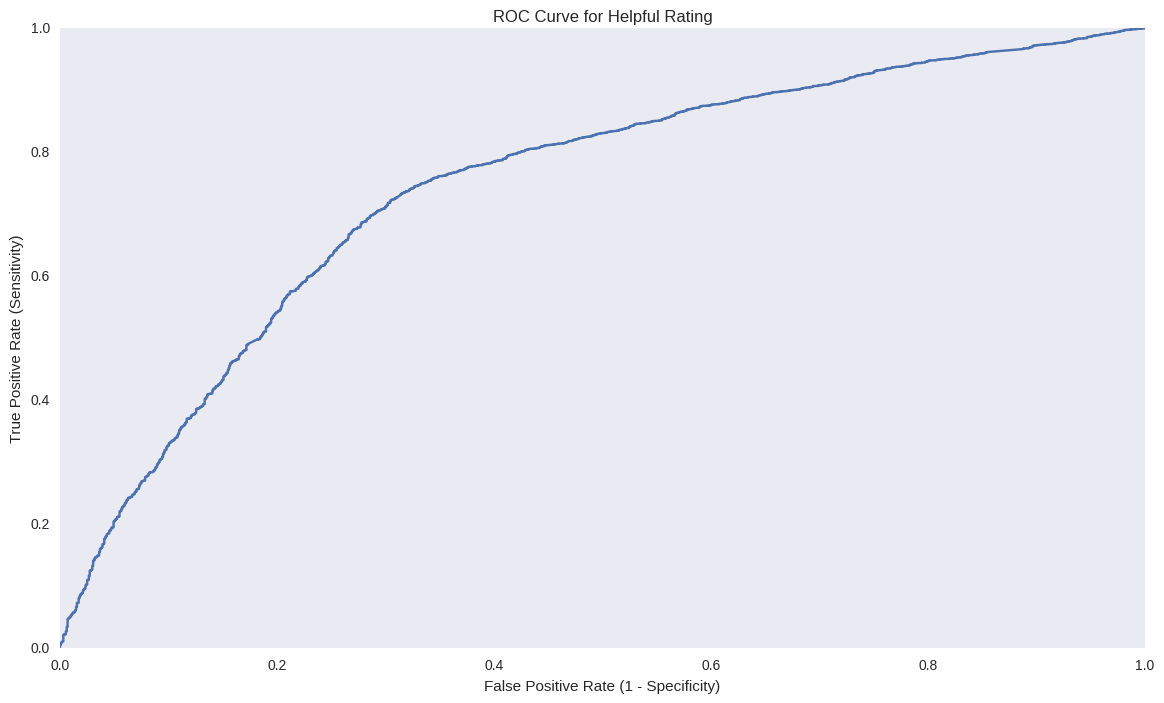

In [55]:
clf = gs.best_estimator_
probas =clf.predict_proba(X_test)
plt.figure(figsize = FIG_SIZE)
plt.plot(roc_curve(y_test, probas[:,1])[0], roc_curve(y_test, probas[:,1])[1])
plt.title('ROC Curve for Helpful Rating')
plt.grid()
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.show

In [56]:
# ROC/AUC score
roc_auc_score(y_test, probas[:,1].T)

0.74415023206073372

## Results

### Model Evaluation and Validation
The final model’s qualities — such as parameters — are evaluated in detail. Some type of analysis is used to validate the robustness of the model’s solution.

### Justification

The final results are compared to the benchmark result or threshold with some type of statistical analysis. Justification is made as to whether the final model and solution is significant enough to have adequately solved the problem.

## Conclusion

### Free-Form Visualization
A visualization has been provided that emphasizes an important quality about the project with thorough discussion. Visual cues are clearly defined.


### Reflection

Student adequately summarizes the end-to-end problem solution and discusses one or two particular aspects of the project they found interesting or difficult.

### Improvement

Discussion is made as to how one aspect of the implementation could be improved. Potential solutions resulting from these improvements are considered and compared/contrasted to the current solution.

## References

1. Inferring networks of substitutable and complementary products. J. McAuley, R. Pandey, J.
Leskovec Knowledge Discovery and Data Mining, 2015.
2. Image-based recommendations on styles and substitutes J. McAuley, C. Targett, J. Shi, A. van
den Hengel SIGIR, 2015.